# Measure proximity to water bodies

We have water bodies as surface water and as coastline. We want to measure whether there is water within 1200m.

In [ ]:
import os

import geopandas as gpd
from shapely.geometry import box
from shapely.ops import polygonize

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

In [2]:
chunk = 51
gdf = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/tessellation/tess_{chunk}.pq')

In [22]:
b = gdf.total_bounds
b

array([332971.42423159, 379462.03      , 361675.        , 404701.        ])

In [4]:
sql = f'SELECT * FROM gb_coastline_2016 WHERE ST_Intersects(geometry, ST_MakeEnvelope({b[0]}, {b[1]}, {b[2]}, {b[3]}, 27700))'
coastline = gpd.read_postgis(sql, engine, geom_col='geometry')

In [5]:
sql = f'SELECT * FROM openmap_surfacewater_area_200824 WHERE ST_Intersects(geometry, ST_MakeEnvelope({b[0]}, {b[1]}, {b[2]}, {b[3]}, 27700))'
water = gpd.read_postgis(sql, engine, geom_col='geometry')

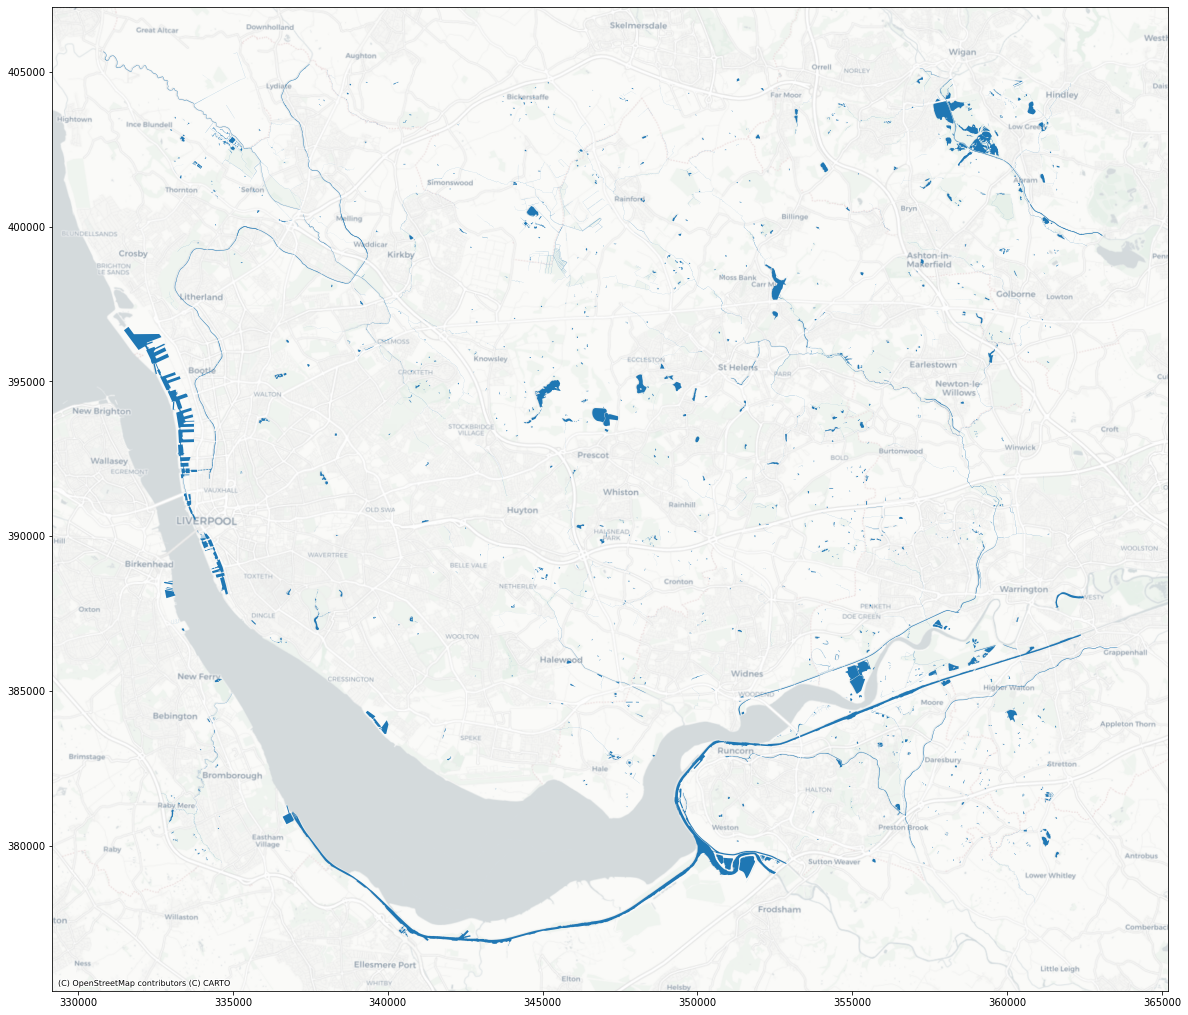

In [7]:
import contextily as ctx
ax = water.plot(figsize=(20, 20))
ctx.add_basemap(ax=ax, crs=water.crs, source=ctx.providers.CartoDB.Positron)

In [20]:
sql = f'SELECT * FROM gb_coastline_2016'
%time coastline = gpd.read_postgis(sql, engine, geom_col='geometry')

%time polys = polygonize(coastline.geometry)
%time land = gpd.GeoSeries(polys, crs=27700)
%time sea = box(*land.total_bounds).difference(land.geometry.unary_union)

CPU times: user 270 ms, sys: 21.2 ms, total: 292 ms
Wall time: 285 ms
CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 30.3 µs
CPU times: user 475 ms, sys: 12.9 ms, total: 488 ms
Wall time: 425 ms
CPU times: user 3.46 s, sys: 39 ms, total: 3.5 s
Wall time: 3.39 s


In [23]:
%%time
target = water.geometry
target.loc[len(water)] = sea
target = gpd.clip(target, box(*b))

CPU times: user 244 ms, sys: 3.79 ms, total: 248 ms
Wall time: 243 ms


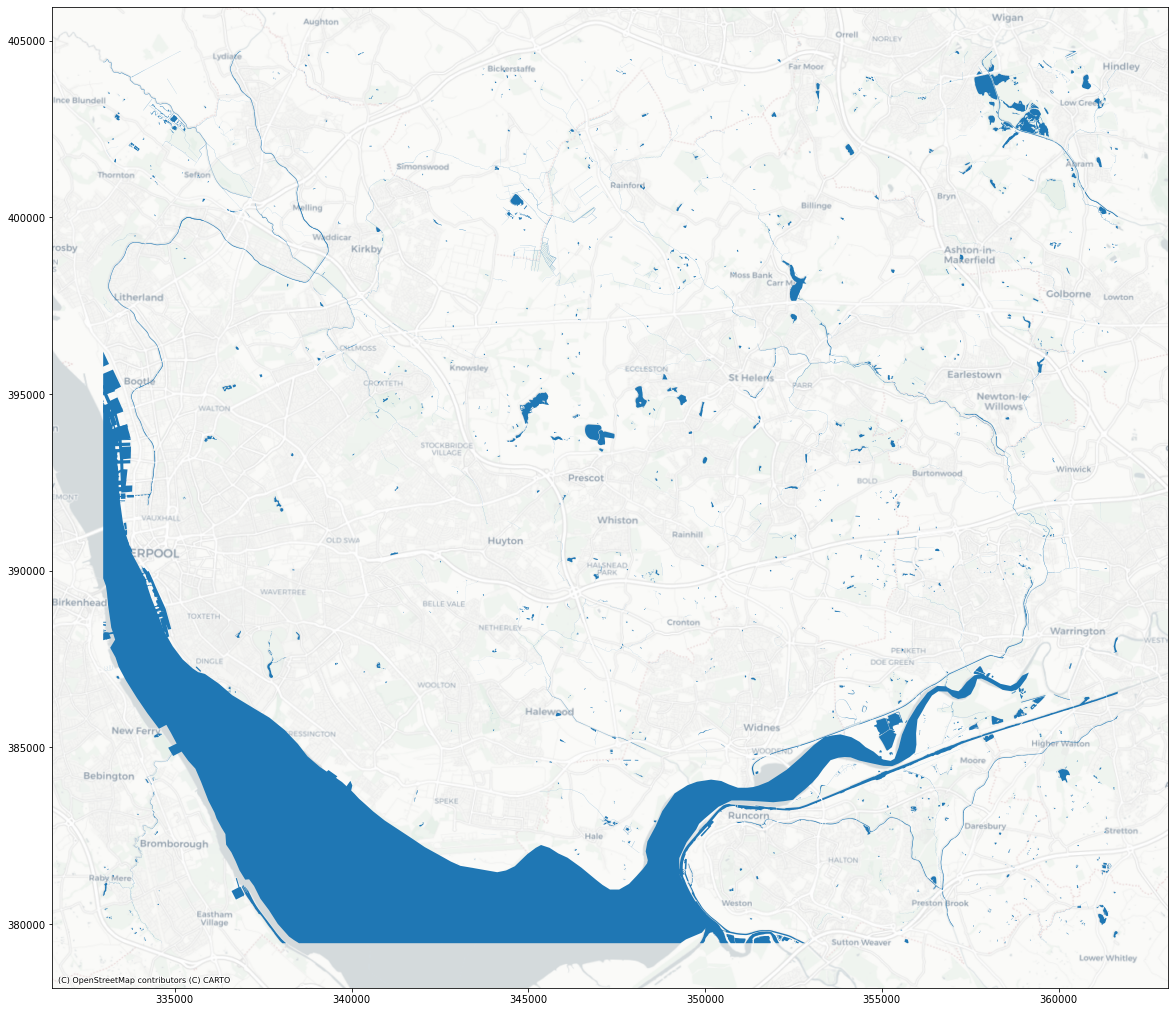

In [10]:
ax = target.plot(figsize=(20, 20))
ctx.add_basemap(ax=ax, crs=water.crs, source=ctx.providers.CartoDB.Positron)

## distance to nearest

In [11]:
from tqdm import tqdm

In [12]:
initial_buffer = 500
buffered = gdf.tessellation.buffer(initial_buffer)
distance = []
for orig, geom in tqdm(zip(gdf.tessellation, buffered.geometry), total=len(buffered)):
    query = target.sindex.query(geom, predicate='intersects')
    b = initial_buffer
    while query.size == 0:
        query = target.sindex.query(geom.buffer(b), predicate='intersects')
        b += initial_buffer
    
    distance.append(target.iloc[query].distance(orig).min())

100%|██████████| 121188/121188 [02:03<00:00, 981.91it/s] 


In [13]:
gdf['dist_nearest'] = distance

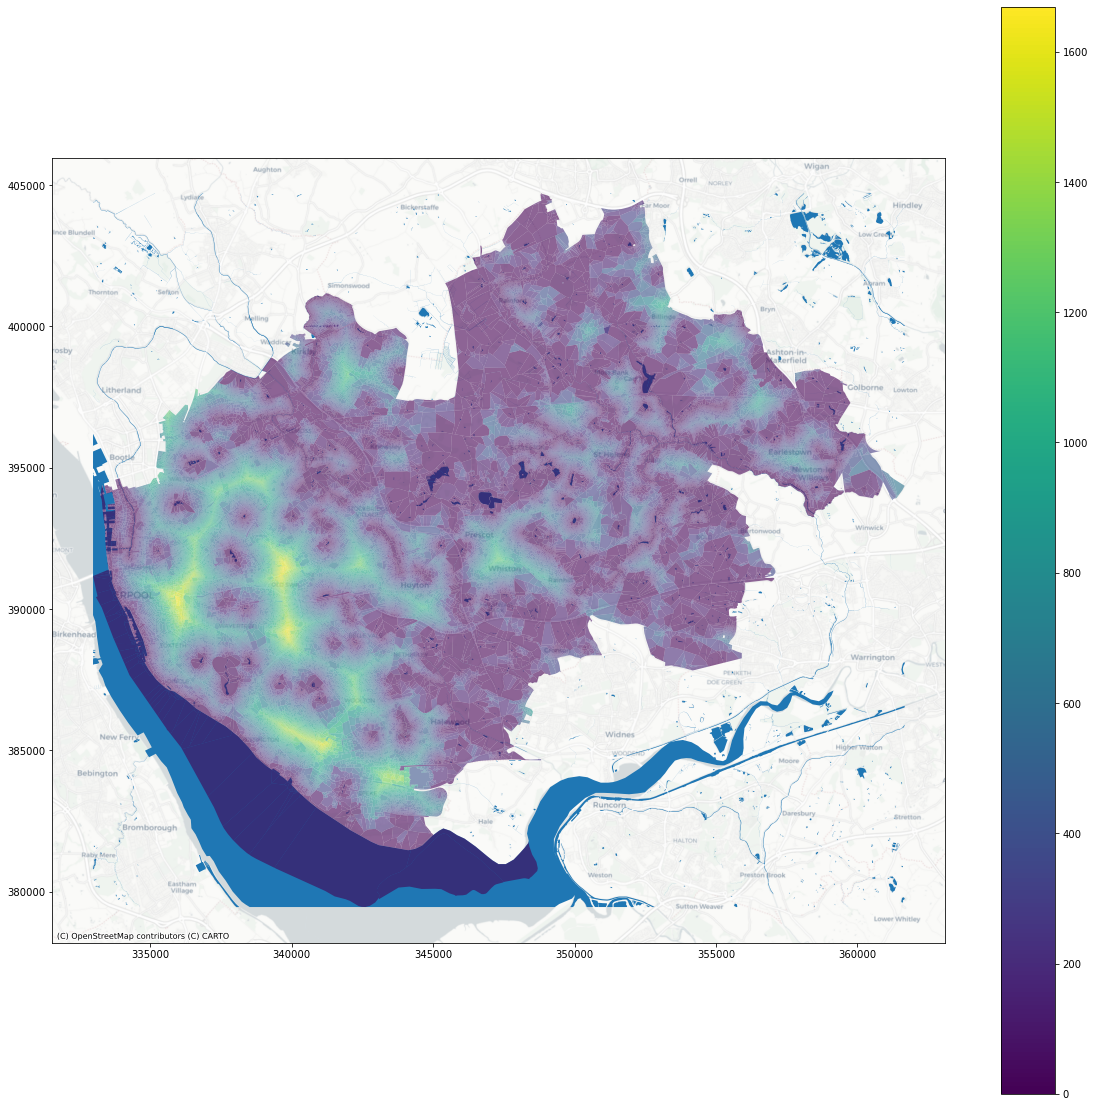

In [14]:
ax = target.plot(figsize=(20, 20))
gdf.plot('dist_nearest', ax=ax, alpha=.6, legend=True)
ctx.add_basemap(ax=ax, crs=water.crs, source=ctx.providers.CartoDB.Positron)

In [24]:
gdf[[hindex]]

hindex                                       tessellation  \
0       c051e628852t0030  POLYGON Z ((344048.361 380866.352 0.000, 34406...   
1       c051e628852t0001  POLYGON Z ((337036.696 383375.034 0.000, 33802...   
2       c051e628852t0000  POLYGON Z ((339421.128 383968.661 0.000, 33928...   
3       c051e628852t0004  POLYGON Z ((340161.989 383494.618 0.000, 34016...   
4       c051e628852t0003  POLYGON Z ((340048.381 383452.693 0.000, 33976...   
...                  ...                                                ...   
121183  c051e132909t0000  POLYGON ((346663.300 402451.280, 346680.510 40...   
121184  c051e132908t0000  POLYGON ((346663.300 402451.280, 346660.820 40...   
121185  c051e132811t0000  POLYGON ((347337.360 402551.380, 347327.100 40...   
121186  c051e132812t0000  POLYGON ((347388.490 402601.430, 347378.490 40...   
121187  c051e132809t0000  POLYGON ((346666.750 402850.450, 346690.980 40...   

                                                buildings  dist_nearest  
0       POLYGON ((347180.960 380917.680, 347180.790 38...      0.000000  
1       POLYGON ((339256.010 384295.120, 339247.960 38...      0.000000  
2       POLYGON ((339284.280 384294.250, 339278.610 38...      0.000000  
3       POLYGON ((340166.180 383506.930, 340154.710 38...      0.000000  
4       POLYGON ((339993.430 383534.490, 339982.390 38...      0.000000  
...                                                   ...           ...  
121183                                               None    198.796515  
121184                                               None    185.367389  
121185  POLYGON ((347331.700 402574.010, 347339.660 40...    326.597412  
121186  POLYGON ((347396.950 402618.750, 347387.330 40...    315.095104  
121187                                               None     12.239010  

[121188 rows x 4 columns]

## Measure distance to nearest water body across the GB

In [2]:
from dask.distributed import Client, LocalCluster, as_completed

In [3]:
workers = 16
client = Client(LocalCluster(n_workers=workers, threads_per_worker=1))
client

<Client: 'tcp://127.0.0.1:35591' processes=16 threads=16, memory=134.91 GB>

In [4]:
from time import time

def measure_nearest(chunk):
    s = time()
    gdf = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/tessellation/tess_{chunk}.pq')
    b = gdf.total_bounds
    engine = create_engine(db_connection_url)
    sql = f'SELECT * FROM gb_coastline_2016 WHERE ST_Intersects(geometry, ST_MakeEnvelope({b[0]}, {b[1]}, {b[2]}, {b[3]}, 27700))'
    coastline = gpd.read_postgis(sql, engine, geom_col='geometry')
    sql = f'SELECT * FROM openmap_surfacewater_area_200824 WHERE ST_Intersects(geometry, ST_MakeEnvelope({b[0]}, {b[1]}, {b[2]}, {b[3]}, 27700))'
    water = gpd.read_postgis(sql, engine, geom_col='geometry')
    
    sql = f'SELECT * FROM gb_coastline_2016'
    coastline = gpd.read_postgis(sql, engine, geom_col='geometry')

    polys = polygonize(coastline.geometry)
    land = gpd.GeoSeries(polys, crs=27700)
    sea = box(*land.total_bounds).difference(land.geometry.unary_union)
    
    target = water.geometry
    target.loc[len(water)] = sea
    target = gpd.clip(target, box(*b))
    
    initial_buffer = 500
    buffered = gdf.tessellation.buffer(initial_buffer)
    distance = []
    for orig, geom in zip(gdf.tessellation, buffered.geometry):
        query = target.sindex.query(geom, predicate='intersects')
        b = initial_buffer
        while query.size == 0:
            query = target.sindex.query(geom.buffer(b), predicate='intersects')
            b += initial_buffer

        distance.append(target.iloc[query].distance(orig).min())
    gdf['nearest_water'] = distance
    gdf[['hindex', 'nearest_water']].to_parquet(f'../../urbangrammar_samba/spatial_signatures/functional/water/water_{chunk}.pq')
    
    return f"Chunk {chunk} processed sucessfully in {time() - s} seconds."

In [5]:
%%time
inputs = iter(range(103))
futures = [client.submit(measure_nearest, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(measure_nearest, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 15 processed sucessfully in 270.0073766708374 seconds.
Chunk 11 processed sucessfully in 295.8281271457672 seconds.
Chunk 0 processed sucessfully in 305.1407525539398 seconds.
Chunk 1 processed sucessfully in 335.0888102054596 seconds.
Chunk 3 processed sucessfully in 340.3261799812317 seconds.
Chunk 9 processed sucessfully in 438.5666627883911 seconds.
Chunk 16 processed sucessfully in 228.68253374099731 seconds.
Chunk 4 processed sucessfully in 499.2042179107666 seconds.
Chunk 7 processed sucessfully in 501.8236873149872 seconds.
Chunk 10 processed sucessfully in 505.2857894897461 seconds.
Chunk 14 processed sucessfully in 507.42315697669983 seconds.
Chunk 2 processed sucessfully in 538.4737710952759 seconds.
Chunk 8 processed sucessfully in 541.1417891979218 seconds.
Chunk 13 processed sucessfully in 601.345691204071 seconds.
Chunk 18 processed sucessfully in 321.98921513557434 seconds.
Chunk 17 processed sucessfully in 333.81971526145935 seconds.
Chunk 21 processed sucessfull

In [7]:
client.close()